In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Add, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


Load Data

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0],True)

data = []
labels = []
dataset_path = '../Vegetable'
classes = os.listdir(dataset_path)
img_rows, img_cols = 40,40


for class_id, class_name in enumerate(classes):
    folder_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(folder_path)
    print(class_id)
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        img = image.load_img(image_path,target_size=(img_rows, img_cols,3),color_mode='rgb')
        img_array = image.img_to_array(img)
        data.append(img_array)
        labels.append(class_id)


X = np.array(data)
Y = np.array(labels)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [4]:
x_train, x_temp, y_train, y_temp = train_test_split(X,Y, test_size=0.2, random_state=int(time.time()))
x_test,x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=int(time.time()))

Preprocessing

In [5]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3).astype('float32')/255.0
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3).astype('float32')/255.0
x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 3).astype('float32')/255.0

In [6]:
#one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, len(classes))
y_test = tf.keras.utils.to_categorical(y_test, len(classes))
y_val = tf.keras.utils.to_categorical(y_val, len(classes))

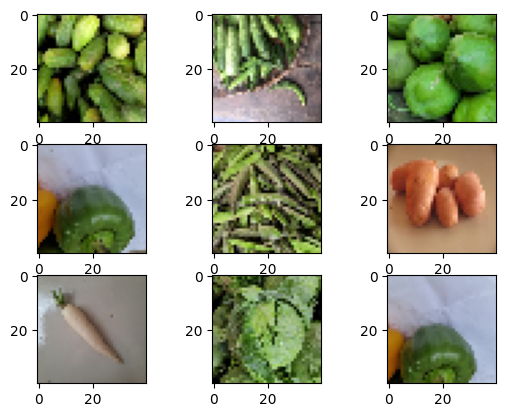

In [7]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], cmap='gray')

plt.show()

In [9]:
def inception_module(x, filters):
    conv1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
    
    conv3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
    conv3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(conv3)

    conv5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
    conv5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(conv5)

    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(filters[3], (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(pool)

    x = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return x

def create_google_net(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    x = Conv2D(32, (7, 7), padding='same', activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    x = BatchNormalization()(x)

    x = inception_module(x, [32, 64, 64, 128, 64,32])
    # x = Dropout(0.5)(x)
    x = inception_module(x, [32, 64, 64, 128, 64,32])

    x = inception_module(x, [64, 128, 128, 256, 128,64])
    # x = Dropout(0.5)(x)
    
    x = inception_module(x, [64, 128, 128, 256, 128,64])
    x = Dropout(0.5)(x)

    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    
    return model



In [10]:
model = create_google_net(input_shape=(img_cols,img_rows,3), num_classes=len(classes))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 40, 40, 32)   4736        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 40, 40, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_2 (Conv2D)              (None, 40, 40, 64)   2112        ['batch_normalization[0][0]']

In [11]:
epochs = 100
batch_size=64

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest',
)


datagen.fit(x_train)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

checkpoint = ModelCheckpoint('best_model.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint,early_stop]
)
score = model.evaluate(x_test,y_test)
print(f"Test score : {score[0]}")
print(f"Test accuraccy : {score[1]}")

Epoch 1/100
263/263 [==============================] - ETA: 0s - loss: 2.1834 - accuracy: 0.4421
Epoch 1: val_loss improved from inf to 2.39768, saving model to best_model.h5
263/263 [==============================] - 93s 323ms/step - loss: 2.1834 - accuracy: 0.4421 - val_loss: 2.3977 - val_accuracy: 0.4005
Epoch 2/100
263/263 [==============================] - ETA: 0s - loss: 1.4912 - accuracy: 0.6557
Epoch 2: val_loss improved from 2.39768 to 1.41875, saving model to best_model.h5
263/263 [==============================] - 81s 309ms/step - loss: 1.4912 - accuracy: 0.6557 - val_loss: 1.4187 - val_accuracy: 0.7195
Epoch 3/100
263/263 [==============================] - ETA: 0s - loss: 1.2206 - accuracy: 0.7460
Epoch 3: val_loss improved from 1.41875 to 1.13410, saving model to best_model.h5
263/263 [==============================] - 81s 310ms/step - loss: 1.2206 - accuracy: 0.7460 - val_loss: 1.1341 - val_accuracy: 0.7695
Epoch 4/100
263/263 [==============================] - ETA: 0s - 

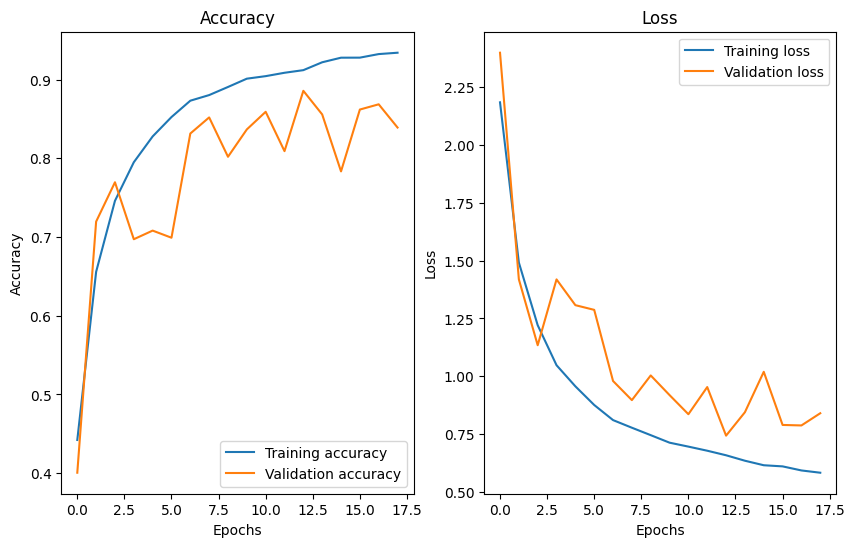

In [12]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('best_model.png')
plt.legend()


In [18]:
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

66/66 [==============================] - 3s 47ms/step


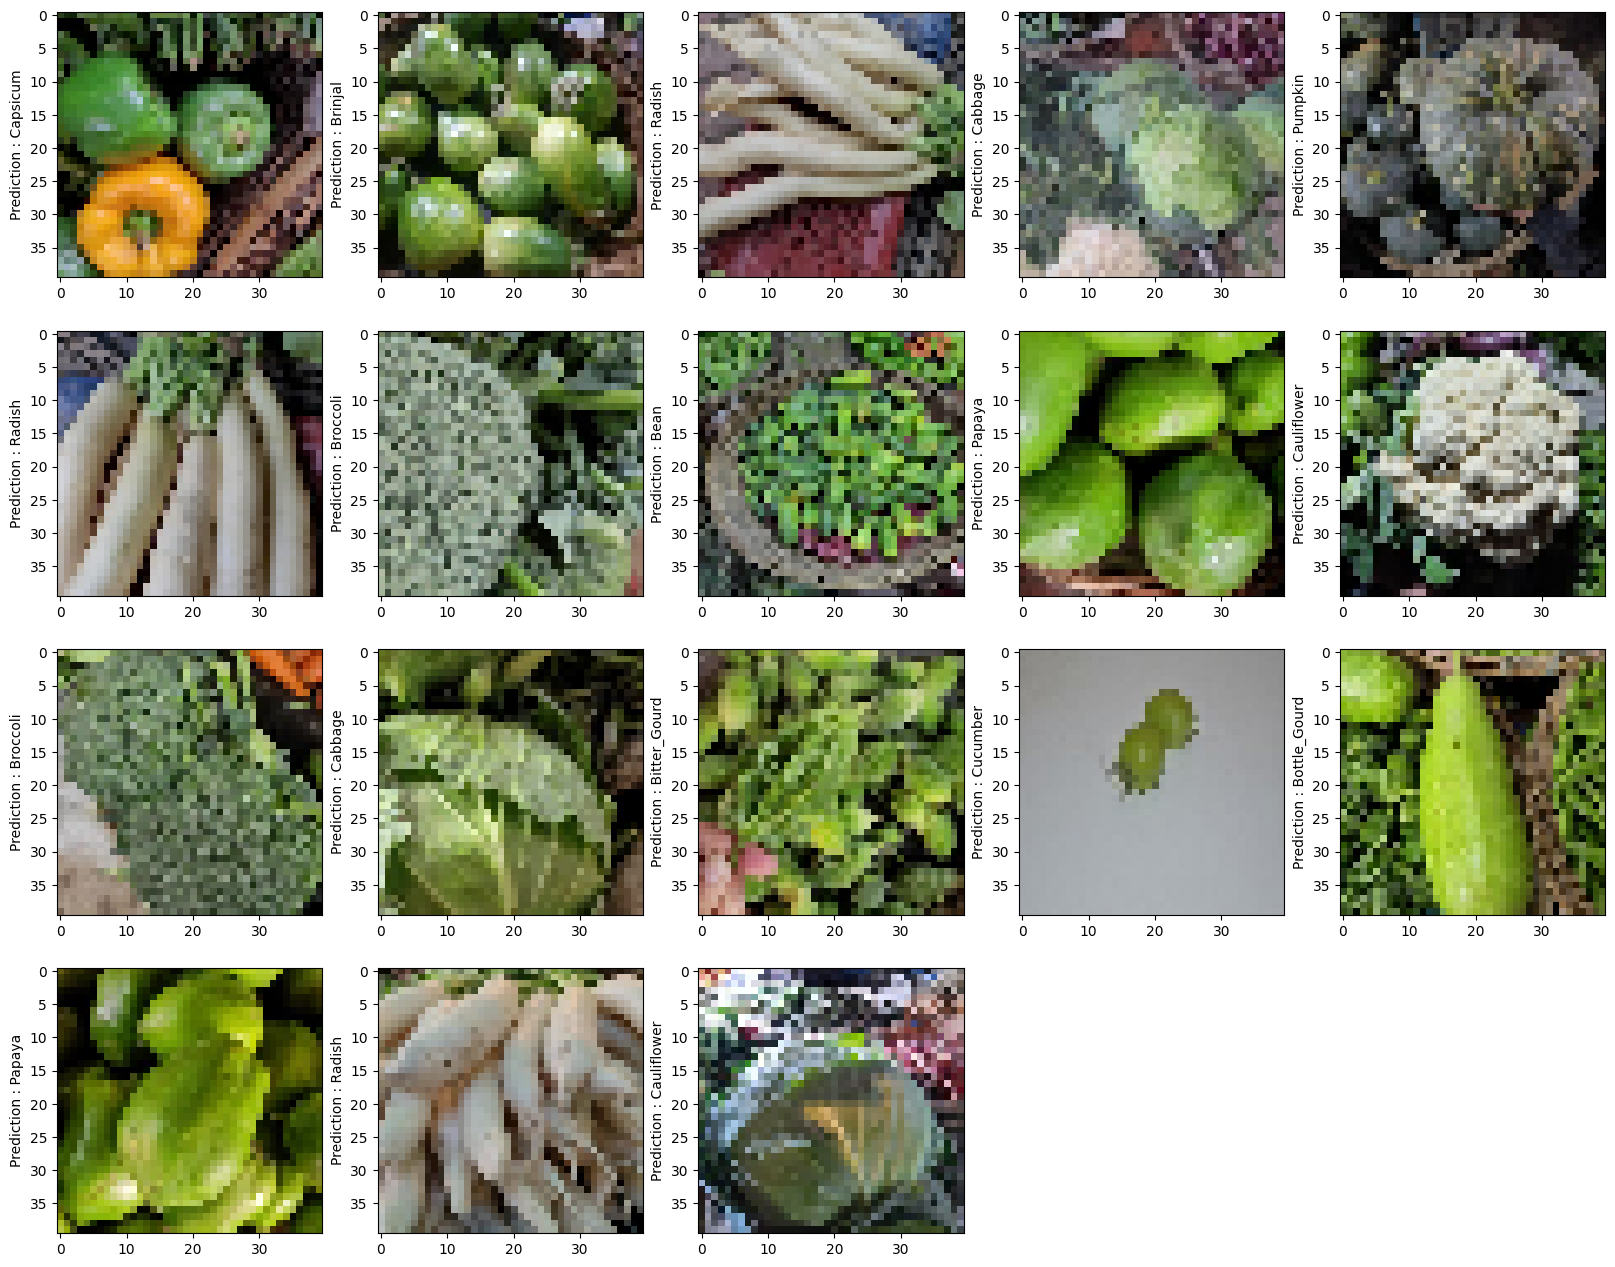

In [19]:
plt.figure(figsize=(20,20))

for i in range(18):
    plt.subplot(5,5,i+1)
    plt.imshow(x_test[i], cmap="gray")
    plt.ylabel(f"Prediction : {classes[predicted_labels[i]]}")

plt.show()